In [2]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
# Strong augmentation for underrepresented class duplicates
strong_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Standard transform for original images
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
class BalancedAugmentDataset(Dataset):
    def __init__(self, root_dir, transform_strong, transform_basic):
        self.root_dir = root_dir
        self.transform_strong = transform_strong
        self.transform_basic = transform_basic

        self.class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}

        self.images_per_class = {cls: [] for cls in self.class_names}
        self.max_class_size = 0

        # Collect all image paths
        for cls in self.class_names:
            cls_dir = os.path.join(root_dir, cls)
            files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            self.images_per_class[cls].extend(files)
            self.max_class_size = max(self.max_class_size, len(files))

        # Balance the dataset
        self.balanced_data = []
        for cls in self.class_names:
            imgs = self.images_per_class[cls]
            needed = self.max_class_size - len(imgs)

            # Original images
            self.balanced_data.extend([(img_path, self.class_to_idx[cls], False) for img_path in imgs])

            # Duplicated + Augmented images
            if needed > 0:
                extra_imgs = random.choices(imgs, k=needed)
                self.balanced_data.extend([(img_path, self.class_to_idx[cls], True) for img_path in extra_imgs])

    def __len__(self):
        return len(self.balanced_data)

    def __getitem__(self, idx):
        img_path, label, should_augment = self.balanced_data[idx]
        image = Image.open(img_path).convert("RGB")

        if should_augment:
            image = self.transform_strong(image)
        else:
            image = self.transform_basic(image)

        return image, label

Dataset length: 96087


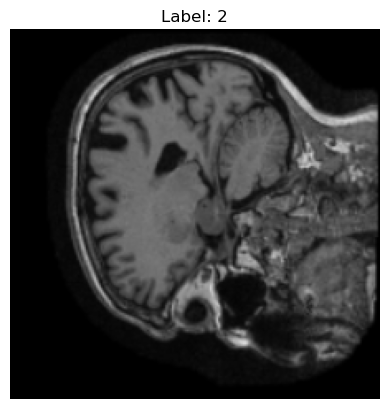

In [43]:
#  set data path
data_path = "./data"

# Create dataset using all classes inside this folder
train_dataset = BalancedAugmentDataset(
    root_dir=data_path,
    transform_strong=strong_augment,
    transform_basic=basic_transform
)

# Wrap in DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Quick check
print("Dataset length:", len(train_dataset))
img, label = train_dataset[67895]
plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [45]:
import os
from torchvision.utils import save_image
from tqdm import tqdm

# 🔁 Map class indices to names (order must match BalancedAugmentDataset)
idx_to_class = {
    0: "AD",
    1: "CN",
    2: "MCI"
}

# 📁 Destination folder
save_root = "./saved_augmented"

# 🚀 Create folders
for class_name in idx_to_class.values():
    os.makedirs(os.path.join(save_root, class_name), exist_ok=True)
print("egs",len(train_dataset))
# 💾 Save images
for i in tqdm(range(len(train_dataset))):
    img, label = train_dataset[i]  # img is a tensor
    class_name = idx_to_class[label]

    save_path = os.path.join(save_root, class_name, f"img_{i:05d}.jpg")
    
    # Denormalize if needed (assuming transforms.Normalize was used)
    denorm = img * 0.5 + 0.5
    save_image(denorm, save_path)

egs 96087


  3%|▎         | 2758/96087 [00:10<05:44, 270.72it/s]


KeyboardInterrupt: 

In [38]:
from collections import Counter

label_counts = Counter()
for _, label in train_dataset:
    label_counts[label] += 1

for k, v in label_counts.items():
    print(f"Class {k} count: {v}")

Class 0 count: 32029
Class 1 count: 32029
Class 2 count: 32029


In [40]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: cpu


In [ ]:
import torch
import os
from torch.utils.data import DataLoader
import torchvision.models as models

# Use all cores for threading
torch.set_num_threads(os.cpu_count())

# Define model
model = models.densenet121(pretrained=True)
model.classifier = torch.nn.Linear(model.classifier.in_features, 3)  # 3 classes
model = model.to(device)

# DataLoader with parallel workers
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count(),  # ← maximize CPU usage
    pin_memory=True              # ← speeds up GPU transfer
)

# Optimizer & loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for imgs, labels in train_loader:
    imgs, labels = imgs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

print("✅ One epoch complete using all CPU cores.")

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py